# PyMC Gaussian Process Toy Model Example

이 노트북은 PyMC를 사용한 Gaussian Process 기반 Bayesian 추론의 완전한 예제를 제공합니다. 컴퓨터 시뮬레이션 데이터와 실제 관측 데이터를 결합하여 물리적 파라미터를 추정하는 방법을 단계별로 설명합니다.

## Bayesian Inference Model

### Overview
이 예제는 Bayesian 추론으로 컴퓨터 시뮬레이션과 실제 관측 데이터를 결합하는 방법을 다룬다. 
Gaussian Process를 에뮬레이터로 사용해 복잡한 물리 시스템의 파라미터를 추정한다.

### Data Model
실제 측정 데이터 $z$는 다음과 같이 모델링한다:

$$
z = \eta(\bold{x}, \bold{\theta}) + e
$$

여기서
- $\eta(\bold{x}, \bold{\theta})$: 실제 물리 프로세스 또는 컴퓨터 시뮬레이션 함수
  - $\bold{x}$: 입력 변수 (예: 공간 좌표, 시간 등)
  - $\bold{\theta}$: 모델 파라미터
- $e$: 관측 오차 (랜덤 노이즈)

### Key Assumptions

**완벽한 모델 가정**: 이 예제는 컴퓨터 모델이 실제 물리 프로세스를 완벽하게 재현한다고 가정한다.

> **참고**: Bayesian Model Calibration (Kennedy and O'Hagan, 2001)에서는 모델의 불완전성을 고려해 오차를 두 부분으로 나눈다:
> - **Model inadequacy (bias)**: 모델 한계로 인한 체계적 오차
> - **Measurement error**: 관측 과정에서 발생하는 랜덤 오차
>
> 하지만 이 예제는 단순화를 위해 모델을 완벽하다고 가정하고, $e$는 시뮬레이터 오차와 관측 오차를 모두 포함한다.

### Gaussian Process Modeling
물리 프로세스 함수 $\eta(\bold{x}, \bold{\theta})$는 제공된 컴퓨터 모델 데이터 혹은 측정 데이터를 기반으로 Gaussian Process (GP)로 모델링한다.

### Data Types

**1. 컴퓨터 시뮬레이션 데이터**
- 형태: $(y_i, \bold{x}_i, \bold{\theta}_i)$
- $y_i$: 시뮬레이션 코드 출력값
- $\bold{x}_i$: 입력 변수
- $\bold{\theta}_i$: 시뮬레이션에 사용된 파라미터값

**2. 실제 관측 데이터**
- 형태: $(z_i, \bold{x}_i, \bold{\theta}_{true})$
- $z_i$: 실제 측정값
- $\bold{x}_i$: 입력 변수 (시뮬레이션과 동일한 조건)
- $\bold{\theta}_{true}$: 실제 물리 프로세스 파라미터이자 추정할 확률변수 (미지수), 모든 $\bold{x}_i$에 대하여 같은 값

### Statistical Model

두 종류 데이터에 대해 다음과 같은 확률적 모델을 설정한다:

**컴퓨터 시뮬레이션 데이터:**
$$
\begin{align}
\{ f_{c,i} \} &\sim \text{GP}(\{ x_i, \theta_i \}) \\
y_i &\sim \mathcal{N}(f_{c,i}, \sigma_c^2) 
\end{align}
$$

**실제 관측 데이터:**
$$
\begin{align}
\{ f_{p,i} \} &\sim \text{GP}(\{ x_i, \theta_{true} \}) \\
z_i &\sim \mathcal{N}(f_{p,i}, \sigma^2) 
\end{align}
$$

여기서
- $f_{c,i}$, $f_{p,i}$: 주어진 입력 변수에 대하여 GP에서 나온 함수값
- $\sigma_c^2$: 컴퓨터 시뮬레이션 오차의 분산
- $\sigma^2$: 실제 관측 오차 분산

### Simplification
이 예제는 단순화를 위해 $\sigma_c = \sigma$로 가정한다.

### Goal
MCMC 샘플링으로 미지의 파라미터 $\theta_{true}$를 추정하고 불확실성을 정량화한다.


## 1. 라이브러리 임포트 및 환경 설정

이 섹션에서는 Bayesian 추론과 Gaussian Process 모델링에 필요한 핵심 라이브러리들을 임포트합니다. 각 라이브러리의 역할과 사용 목적을 명확히 이해하는 것이 중요합니다.

이 예제에서 사용되는 주요 라이브러리들입니다:

### 핵심 라이브러리
- **`pymc`**: Bayesian 통계 모델링과 MCMC (Markov Chain Monte Carlo) 추론을 위한 메인 라이브러리
  - 확률적 프로그래밍을 통해 복잡한 Bayesian 모델을 쉽게 구축
  - 다양한 MCMC 샘플러 (NUTS, Metropolis-Hastings 등) 제공
  - Gaussian Process 모델링 지원

- **`numpy`**: 수치 연산과 다차원 배열 처리
  - 기본적인 수학 연산 및 선형대수 연산
  - 데이터 생성, 변환, 통계 계산에 사용

### 데이터 처리 및 분석
- **`arviz`**: Bayesian 분석 결과의 요약 및 시각화
  - MCMC 체인 진단 및 수렴성 검사
  - 사후 분포 시각화 및 요약 통계
  - Trace plot, posterior plot 등 다양한 시각화 도구 제공

- **`pandas`**: 표 형식 데이터의 입출력 및 분석
  - CSV 파일 읽기/쓰기
  - 데이터프레임 조작 및 전처리
  - 구조화된 데이터 관리

### 시각화
- **`matplotlib.pyplot`**: 2D 데이터 시각화
  - 플롯 생성 및 커스터마이징
  - 결과 시각화 및 분석 도표 작성

### 저수준 연산 지원
- **`pytensor.tensor`**: 텐서 연산 지원 (PyMC 내부 연산에 사용)
  - PyMC의 백엔드로 사용되는 심볼릭 텐서 라이브러리
  - 그래디언트 계산 및 자동 미분 지원
  - 수식 연산을 사용할때 넘파이처럼 사용해야하며 PyMC 내부에서 중요한 역할을 함


In [1]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import pytensor.tensor as pt

## 2. 데이터 임포트 및 탐색적 분석

이 섹션에서는 컴퓨터 시뮬레이션 데이터와 실제 관측 데이터를 로드하고 기본적인 탐색적 분석을 수행합니다. 데이터의 구조와 특성을 이해하는 것이 올바른 모델링의 첫 단계입니다.

In [2]:
# 데이터 파일 로드
# c는 computed (계산된 시뮬레이션 데이터), f는 field (실제 관측된 물리적 프로세스 데이터)를 의미합니다.
df_c = pd.read_csv("../dataset/datacomp_hourly.csv")  # 컴퓨터 시뮬레이션 데이터
df_f = pd.read_csv("../dataset/datafield_hourly.csv")  # 실제 관측 데이터

In [3]:
# 컴퓨터 시뮬레이션 데이터 구조 설명
# - yc: 에너지 사용량 (시뮬레이션 출력값)
# - xc1: 외기온도 (첫 번째 입력 변수)
# - xc2: 상대습도 (두 번째 입력 변수)
# - tc1: 추론하고자 하는 파라미터1 (기기밀도)
# - tc2: 추론하고자 하는 파라미터2 (조명밀도)
# - tc3: 추론하고자 하는 파라미터3 (COP - Coefficient of Performance)

print("컴퓨터 시뮬레이션 데이터 구조:")
df_c

컴퓨터 시뮬레이션 데이터 구조:


,yc,xc1,xc2,tc1,tc2,tc3
0,128.62,25.80,76.83,8.56,5.37,3.10
1,96.13,25.62,77.17,8.56,5.37,3.10
2,85.19,25.32,79.17,8.56,5.37,3.10
3,85.19,25.03,81.17,8.56,5.37,3.10
4,81.71,24.73,83.17,8.56,5.37,3.10
...,...,...,...,...,...,...
235,548.76,27.22,74.58,9.26,7.65,2.89
236,504.63,26.62,75.58,9.26,7.65,2.89
237,439.27,26.32,76.58,9.26,7.65,2.89
238,348.70,26.03,78.75,9.26,7.65,2.89


In [4]:
# 실제 관측 데이터 구조 설명
# - yf: 에너지 사용량 (실제 측정값)
# - xf1: 외기온도 (첫 번째 입력 변수)
# - xf2: 상대습도 (두 번째 입력 변수)
# 주의: 실제 데이터에는 추정하고자 하는 파라미터(tc1, tc2, tc3)가 없습니다.
# 이 파라미터들이 우리가 Bayesian 추론을 통해 찾고자 하는 미지수입니다.

print("실제 관측 데이터 구조:")
df_f

실제 관측 데이터 구조:


,yf,xf1,xf2
0,143.62,25.80,76.83
1,109.34,25.63,77.17
2,95.08,25.33,79.17
3,95.08,25.03,81.17
4,90.93,24.73,83.17
5,97.50,24.43,85.17
6,123.77,24.13,87.17
7,159.02,23.83,89.17
8,134.83,23.99,89.42
9,103.03,24.67,86.67


## 3. 데이터 시각화 및 탐색적 분석

데이터의 공간적 분포와 패턴을 이해하기 위해 시각화를 수행합니다. 이를 통해 데이터의 특성과 잠재적인 관계를 파악할 수 있습니다.

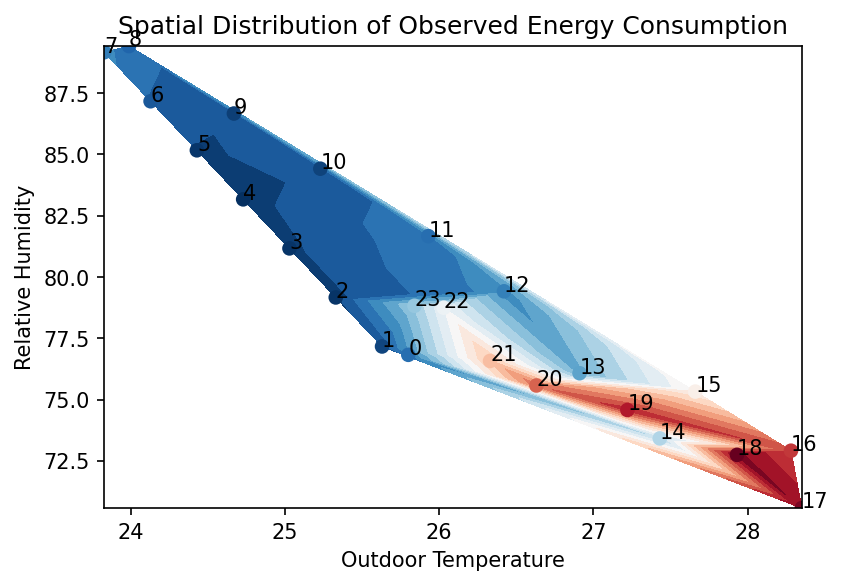

In [5]:
# 실제 물리 프로세스 데이터(df_f)의 2차원 공간 분포를 시각화
# df_f 구조: [zf, xf1, xf2] - 실제 측정값과 2차원 공간 좌표

# 고해상도 플롯 설정 (6x4 인치, 150 DPI)
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)

# 삼각분할 등고선 플롯 (filled contour)
# df_f.iloc[:, 1]: x1 좌표 (공간의 첫 번째 차원), 건구온도
# df_f.iloc[:, 2]: x2 좌표 (공간의 두 번째 차원), 상대습도  
# df_f.iloc[:, 0]: zf 값 (실제 측정값, 등고선의 높이로 표현)
# levels=20: 20개의 등고선 레벨로 세밀한 분포 표현
# cmap="RdBu_r": 빨강-파랑 색상 맵 (역순, 높은 값이 파란색)
ax.tricontourf(
    df_f.iloc[:, 1],
    df_f.iloc[:, 2],
    df_f.iloc[:, 0],
    levels=20,
    cmap="RdBu_r"
)

# 실제 데이터 포인트들을 산점도로 표시
# 각 점의 색상은 해당 위치의 측정값(zf)에 따라 결정
ax.scatter(
    df_f.iloc[:, 1],
    df_f.iloc[:, 2],
    c=df_f.iloc[:, 0],
    cmap="RdBu_r"
)

# 각 데이터 포인트에 인덱스 번호를 텍스트로 표시
for i in range(df_f.shape[0]):
    ax.text(
        df_f.iloc[i, 1],  # x1 좌표
        df_f.iloc[i, 2],  # x2 좌표
        str(i),           # 포인트 인덱스 번호
        color="black"     # 검은색 텍스트
    )

# 축 레이블과 제목 설정
ax.set_xlabel("Outdoor Temperature")
ax.set_ylabel("Relative Humidity")
ax.set_title("Spatial Distribution of Observed Energy Consumption")

plt.show()

## 4. Bayesian Inference 모델 정의

이 섹션에서는 PyMC를 사용하여 Gaussian Process 기반 Bayesian 모델을 정의합니다. 모델은 컴퓨터 시뮬레이션 데이터와 실제 관측 데이터를 통합하여 물리적 파라미터를 추정합니다.

### 4-1. 데이터 탐색 및 통계 요약

모델 정의 전에 데이터의 기본 통계량을 확인하여 데이터의 특성과 분포를 이해합니다.

In [6]:
# 컴퓨터 시뮬레이션 데이터의 기본 통계량 확인
# 데이터의 분포, 범위, 중심 경향 등을 파악하여 적절한 사전 분포 설정에 활용
print("컴퓨터 시뮬레이션 데이터 통계 요약:")
df_c.describe()

컴퓨터 시뮬레이션 데이터 통계 요약:


,yc,xc1,xc2,tc1,tc2,tc3
count,240.000000,240.00000,240.000000,240.000000,240.000000,240.000000
mean,238.212208,25.98625,79.417500,8.001000,6.422000,2.916000
std,153.872389,1.33510,5.316637,0.919768,0.734154,0.337964
min,81.710000,23.82000,70.580000,6.630000,5.370000,2.430000
25%,111.735000,24.95500,75.517500,7.100000,5.720000,2.610000
50%,161.390000,25.88000,78.790000,8.015000,6.360000,2.905000
75%,355.855000,26.98750,83.482500,8.670000,7.170000,3.240000
max,590.090000,28.35000,89.420000,9.340000,7.650000,3.450000


In [7]:
# 실제 관측 데이터의 기본 통계량 확인
# 시뮬레이션 데이터와의 비교를 통해 데이터의 일관성과 차이점을 파악
print("실제 관측 데이터 통계 요약:")
df_f.describe()

실제 관측 데이터 통계 요약:


,yf,xf1,xf2
count,24.000000,24.000000,24.00000
mean,237.079167,25.990000,79.41750
std,154.280131,1.359767,5.41966
min,90.930000,23.830000,70.58000
25%,108.802500,24.955000,75.51750
50%,160.140000,25.885000,78.79000
75%,339.160000,26.987500,83.48250
max,533.400000,28.350000,89.42000


### 4-2. 데이터 정규화 (Data Normalization)

Bayesian 추론과 Gaussian Process 모델링에서 데이터 정규화는 수치적 안정성과 수렴성을 위해 필수적입니다.


In [20]:
# 데이터 정규화 (Min-Max Scaling)
# 모든 데이터를 [0, 1] 범위로 정규화하여 Gaussian Process 모델링의 수치적 안정성을 확보합니다.

print("=== 컴퓨터 시뮬레이션 데이터 정규화 ===")

# 1. 시뮬레이션 출력값 (y) 정규화
# df_c.iloc[:, 0]: 시뮬레이션 코드의 출력값들
y = df_c.iloc[:, 0].values
y_min = y.min()  # 최솟값 저장 (나중에 역변환용)
y_max = y.max()  # 최댓값 저장 (나중에 역변환용)
y = (y - y_min) / (y_max - y_min)  # Min-Max 정규화: (값 - 최솟값) / (최댓값 - 최솟값)
print(f"y 정규화: 원본 범위 [{y_min:.2f}, {y_max:.2f}] → 정규화 범위 [0, 1]")

# 2. 시뮬레이션 입력 변수 (x_c) 정규화  
# df_c.iloc[:, 1:3]: 공간 좌표 (x1, x2)
x_c = df_c.iloc[:, 1:3].values
x_c_min = x_c.min(axis=0)  # 각 차원별 최솟값
x_c_max = x_c.max(axis=0)  # 각 차원별 최댓값
x_c = (x_c - x_c_min) / (x_c_max - x_c_min)  # 차원별로 Min-Max 정규화
print("x_c 정규화: 각 차원별로 [0, 1] 범위로 변환")

# 3. 시뮬레이션 추가 입력 파라미터, 추정 파라미터 (t_c) 정규화
# df_c.iloc[:, 3:]: 모델 추정 파라미터 (t1, t2, t3)
theta = df_c.iloc[:, 3:].values
theta_min = 0  # 하한선을 0으로 고정 (양수 파라미터)
theta_max = theta.max(axis=0)  # 각 파라미터별 최댓값
theta = (theta - theta_min) / (theta_max - theta_min)  # [0, 최댓값] → [0, 1] 범위로 정규화
print(f"theta 정규화: [0, {theta_max}] → [0, 1] 범위로 변환")

print(f"정규화된 데이터 크기: {y.shape = }, {x_c.shape = }, {theta.shape = }")

# 4. 실제 관측 데이터 정규화
# 위에서 사용된 정규화 파라미터를 실험 데이터 정규화에도 그대로 적용합니다.
# 이를 통해 관측 데이터와 시뮬레이션 데이터가 같은 스케일에서 비교 가능합니다.
z = df_f.iloc[:, 0].values
z = (z - y_min) / (y_max - y_min)  # y의 정규화 파라미터 사용
print(f"z 정규화: y와 동일한 스케일 적용 [{y_min = :.2f}, {y_max = :.2f}] → [0, 1]")

# 5. 실제 관측 좌표 (x_p) 정규화
# 시뮬레이션 좌표와 같은 스케일을 적용
x_p = df_f.iloc[:, 1:3].values
x_p = (x_p - x_c_min) / (x_c_max - x_c_min)  # x_c의 정규화 파라미터 사용
print("x_p 정규화: x_c와 동일한 스케일 적용")

print(f"정규화된 데이터 크기: {z.shape = }, {x_p.shape = }")

=== 컴퓨터 시뮬레이션 데이터 정규화 ===
y 정규화: 원본 범위 [81.71, 590.09] → 정규화 범위 [0, 1]
x_c 정규화: 각 차원별로 [0, 1] 범위로 변환
theta 정규화: [0, [9.34 7.65 3.45]] → [0, 1] 범위로 변환
정규화된 데이터 크기: y.shape = (240,), x_c.shape = (240, 2), theta.shape = (240, 3)
z 정규화: y와 동일한 스케일 적용 [y_min = 81.71, y_max = 590.09] → [0, 1]
x_p 정규화: x_c와 동일한 스케일 적용
정규화된 데이터 크기: z.shape = (24,), x_p.shape = (24, 2)


### 4-3. PyMC 모델 정의 및 구조

## PyMC 모델 정의

### 모델 구조 개요

이 섹션에서는 Bayesian 추론을 위한 PyMC 모델을 정의합니다. 모델은 다음과 같은 핵심 구성요소를 포함합니다:

1. **Gaussian Process 커널 정의**
2. **하이퍼파라미터 사전 분포 설정**
3. **데이터 통합 및 관측 모델 구성**
4. **Marginal GP 구현**

### 1. Gaussian Process 하이퍼파라미터

#### Length-Scale 파라미터 (`l`)
```python
l = pm.Gamma("l", alpha=2, beta=0.5, shape=5)
```

- **분포**: Gamma(α=2, β=0.5)
- **차원**: 5차원 (x₁, x₂, t₁, t₂, t₃에 대응)
- **물리적 의미**: 각 입력 차원에서 함수의 변동성 정도
- **제약**: 양수만 가능 (분모에 사용되므로 0이면 안됨)

**수학적 표현**:
$$l_i \sim \text{Gamma}(2, 0.5), \quad i = 1, 2, 3, 4, 5$$

#### Amplitude 파라미터 (`eta`)
```python
eta = pm.HalfCauchy("eta", beta=1)
```

- **분포**: HalfCauchy(β=1)
- **물리적 의미**: 함수 값의 전체적인 변동 폭
- **제약**: 0 이상 (함수 값의 스케일 결정)

**수학적 표현**:
$$\eta \sim \text{HalfCauchy}(1)$$

### 2. 커널 함수 정의

```python
cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=5, ls=ls)
```

**Exponential Quadratic (RBF) 커널**을 사용합니다:

$$k(x_i, x_j) = \eta^2 \exp\left(-\frac{1}{2}\sum_{d=1}^{5}\frac{(x_{i,d} - x_{j,d})^2}{l_d^2}\right)$$

여기서:
- $\eta^2$: 함수 값의 변동 폭
- $l_d$: 각 차원 $d$의 length-scale
- 5차원 입력: $(x_1, x_2, t_1, t_2, t_3)$

### 3. 데이터 통합

#### 입력 데이터 결합
```python
X_c = np.hstack([x_c, theta])  # 시뮬레이션 데이터
X_p = pt.concatenate([x_p, pt.tile(theta, (x_p.shape[0], 1))], axis=1)  # 실제 관측 데이터
```

- **시뮬레이션**: $(x_c, theta)$ → 5차원 입력
- **실제 관측**: $(x_p, \theta)$ → 모든 관측점에서 동일한 $\theta$ 사용

#### 최종 데이터 통합
```python
X = pt.concatenate([X_c, X_p], axis=0)
Y = pt.concatenate([y, z], axis=0)
```

### 4. 모델 파라미터 정의

#### 물리적 파라미터 (`theta_true`)
```python
theta_true = pm.Exponential("theta_true", lam=1, shape=3)
```

- **분포**: Exponential(λ=1)
- **차원**: 3차원 (t₁, t₂, t₃)
- **제약**: 양수만 가능 (물리적 제약)
- **의미**: 실제 물리 프로세스의 미지 파라미터

**수학적 표현**:
$$\theta_{true,i} \sim \text{Exponential}(1), \quad i = 1, 2, 3$$

#### 관측 노이즈 (`sigma`)
```python
sigma = pm.HalfNormal("sigma", sigma=0.02)
```

- **분포**: HalfNormal(σ=0.02)
- **의미**: 관측 과정에서 발생하는 랜덤 노이즈
- **제약**: 양수만 가능

**수학적 표현**:
$$\sigma \sim \text{HalfNormal}(0.02)$$

### 5. Marginal Gaussian Process 구현

#### 왜 Marginal GP를 사용하는가?

**Gaussian Noise 가정** 하에서 Marginal GP가 수치적으로 효율적입니다:

**Latent GP 접근법**:
1. $P(\mathbf{f} | X, \eta, l)$에서 $\mathbf{f}$ 샘플링
2. $P(y | \mathbf{f}, \sigma) = \mathcal{N}(\mathbf{f}, \sigma^2)$에서 관측치 예측

**Marginal GP 접근법**:
$$\int P(y | \mathbf{f}, \sigma) P(\mathbf{f} | X, \eta, l) d\mathbf{f}$$

이 적분의 **해석해**가 존재하므로 중간 변수 $\mathbf{f}$ 없이 바로 관측치를 예측할 수 있습니다.

**조건**: $P(y | \mathbf{f}, \sigma)$가 정규분포일 때만 해석해 존재

#### Marginal Likelihood 정의
```python
gp = pm.gp.Marginal(cov_func=cov)
obs = gp.marginal_likelihood("obs", X=X, y=Y, sigma=sigma)
```

**수학적 표현**:
$$\log p(Y | X, \theta, \eta, l, \sigma) = -\frac{1}{2}Y^T K^{-1} Y - \frac{1}{2}\log|K| - \frac{n}{2}\log(2\pi)$$

여기서 $K = K_{XX} + \sigma^2 I$ (커널 행렬 + 노이즈 항)

### 6. 모델의 확률적 구조

전체 모델은 다음과 같은 계층적 구조를 가집니다:

$$\begin{align}
\theta_d &\sim \text{Exponential}(1) \\
l_d &\sim \text{Gamma}(2, 0.5) \\
\eta &\sim \text{HalfCauchy}(1) \\
\sigma &\sim \text{HalfNormal}(0.02) \\
Y &\sim \mathcal{N}(0, K_{XX} + \sigma^2 I)
\end{align}$$

여기서 $K_{XX}$는 입력 $X$에 대한 커널 행렬입니다.

### 7. 구현의 장점

1. **수치적 효율성**: Marginal likelihood 사용으로 차원 축소
2. **수렴성**: 적절한 사전 분포로 MCMC 수렴 향상
3. **해석성**: 각 파라미터의 물리적 의미가 명확
4. **확장성**: 다양한 커널과 노이즈 모델로 확장 가능

> **참고**: [PyMC GP Marginal Implementation](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-Marginal.html)



In [9]:
with pm.Model() as model:
    # 1. Gaussian Process 하이퍼파라미터 정의
    # 5차원 입력 공간 (x1, x2, t1, t2, t3)에 대한 GP 커널 설정
    
    # Length-scale 파라미터: 각 입력 차원에서의 함수 변동성 특성을 제어
    # Gamma 분포 사용 이유: 양수만 허용 (분모에 사용되므로 0이면 안됨)
    # shape=5: 5개 입력 차원 각각에 대한 독립적인 length-scale
    l = pm.Gamma("l", alpha=2, beta=0.5, shape=5)

    # Amplitude 파라미터: GP 함수 값의 전체적인 변동 폭을 결정
    # HalfCauchy 분포 사용 이유: 0을 포함한 양수 허용, heavy-tail로 유연한 사전 분포
    eta = pm.HalfCauchy("eta", beta=1)

    # 2. 커널 함수 정의
    # Exponential Quadratic (RBF) 커널: 가장 일반적으로 사용되는 smooth한 함수 근사 커널
    # k(x_i, x_j) = eta^2 * exp(-0.5 * sum((x_i - x_j)^2 / ls^2))
    cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=5, ls=l)

    # 3. 시뮬레이션 데이터 입력 구성
    # x_c (공간 좌표)와 theta (파라미터)를 수평으로 결합하여 5차원 입력 생성
    X_c = np.hstack([x_c, theta])
 
    # 4. 물리적 파라미터 추정을 위한 사전 분포 정의
    
    # theta_true: 추정하고자 하는 미지의 물리적 파라미터 (t1, t2, t3)
    # Exponential 분포 사용 이유: 
    #   - 파라미터가 음수가 될 수 없는 물리적 제약
    #   - lam=1로 약한 정보만 제공하여 데이터가 추론을 주도하도록 설정
    theta_true = pm.Exponential("theta_true", lam=1, shape=3)

    # 실제 관측 데이터 입력 구성
    # 모든 관측치가 동일한 물리 시스템(동일한 theta)에서 나왔다고 가정
    # pt.tile을 사용하여 theta를 관측치 개수만큼 복제
    X_p = pt.concatenate([x_p, pt.tile(theta_true, (x_p.shape[0], 1))], axis=1)
    
    # 5. 관측 노이즈 정의
    # sigma: 측정 과정에서 발생하는 랜덤 노이즈의 표준편차
    # HalfNormal 분포 사용 이유: 양수 제약, 데이터 정규화로 인해 작은 값(0.02) 사용
    sigma = pm.HalfNormal("sigma", sigma=0.02)

    # 6. 시뮬레이션과 실제 관측 데이터 통합
    # 두 데이터셋을 수직으로 결합하여 하나의 GP로 모델링
    # 이를 통해 시뮬레이션 정보가 theta 추정에 활용됨
    X = pt.concatenate([X_c, X_p], axis=0)  # 입력: 시뮬레이션 + 관측 좌표
    Y = pt.concatenate([y, z], axis=0)      # 출력: 시뮬레이션 + 관측 데이터

    # 7. Marginal Gaussian Process 정의
    # GP의 평균 함수는 0으로 가정 (커널 함수만으로 데이터 패턴을 충분히 표현)
    # Marginal GP 사용 이유: 
    #   - Latent 변수를 적분하여 제거, 계산 효율성 향상
    #   - 정규분포 노이즈 가정 하에서 해석적 marginal likelihood 계산 가능
    gp = pm.gp.Marginal(cov_func=cov)
    obs = gp.marginal_likelihood("obs", X=X, y=Y, sigma=sigma)

## 모델 구조 시각화 해석

위의 그래프는 우리가 정의한 PyMC 모델의 **확률적 그래픽 모델(Probabilistic Graphical Model, PGM)**을 시각화한 것입니다. 이 다이어그램은 Bayesian 모델의 구조와 변수 간의 의존성을 명확하게 보여줍니다.

### 그래프 구성 요소 설명

#### 1. **노드 (Nodes)**
각 원형 노드는 모델의 확률 변수를 나타냅니다:

- **회색 음영 노드**: 관측된 데이터 (Observed Data)
- **흰색 노드**: 잠재 변수 또는 하이퍼파라미터 (Latent Variables/Hyperparameters)

#### 2. **화살표 (Arrows)**
화살표는 변수 간의 **조건부 의존성**을 나타냅니다:
- A → B: B의 분포가 A의 값에 의존함을 의미

#### 3. **플레이트 (Plates)**
사각형 플레이트는 **반복 구조**를 나타냅니다:
- 플레이트 내의 변수가 여러 번 반복됨을 의미
- 플레이트 우하단의 숫자는 반복 횟수를 나타냄

### 각 변수별 상세 해석

#### **하이퍼파라미터들**

**1. `l ~ Gamma` (Length-scale)**
- **분포**: Gamma(2, 0.5)
- **차원**: 5차원 (플레이트 숫자 5)
- **의미**: 각 입력 차원(x₁, x₂, t₁, t₂, t₃)에 대한 GP length-scale
- **물리적 해석**: 각 차원에서 함수의 변동성 정도

**2. `eta ~ HalfCauchy` (Amplitude)**
- **분포**: HalfCauchy(1)
- **의미**: GP 함수의 전체적인 변동 폭
- **물리적 해석**: 함수 값의 스케일 파라미터

**3. `sigma ~ HalfNormal` (Observation Noise)**
- **분포**: HalfNormal(0.02)
- **의미**: 관측 과정에서 발생하는 랜덤 노이즈의 표준편차
- **물리적 해석**: 측정 오차의 크기

**4. `theta_true ~ Exponential` (Physical Parameters)**
- **분포**: Exponential(1)
- **차원**: 3차원 (플레이트 숫자 3)
- **의미**: 실제 물리 프로세스의 미지 파라미터
- **물리적 해석**: 추정하고자 하는 물리적 특성값들

#### **관측 데이터**

**5. `obs ~ Multivariate_normal` (Observed Data)**
- **분포**: Multivariate Normal
- **차원**: 264개 관측치 (플레이트 숫자 264)
- **구성**: 시뮬레이션 데이터(y) + 실제 관측 데이터(z) 통합
- **의미**: 모든 하이퍼파라미터에 조건부로 분포하는 관측값들

### 모델의 계층적 구조

```
계층 1 (하이퍼파라미터): ls, eta, sigma, theta_true
                           ↓ (조건부 의존성)
계층 2 (관측 데이터): obs
```

### 수학적 관계

모든 하이퍼파라미터가 관측 데이터의 분포에 영향을 미치는 구조:

$$p(obs | l, \eta, \sigma, \theta) = \mathcal{N}(0, K_{XX} + \sigma^2 I)$$

여기서 $K_{XX}$는 다음과 같이 정의됩니다:
$$K_{XX} = \eta^2 \cdot \text{ExpQuad}(X, X; l)$$

### 모델의 특징

1. **단일 관측 노드**: 시뮬레이션과 실제 데이터를 하나의 관측 모델로 통합
2. **Marginal GP**: 중간 변수 없이 직접 관측 데이터를 모델링
3. **벡터화된 파라미터**: `l`와 `theta_true`가 다차원 벡터로 모델링
4. **계층적 구조**: 모든 하이퍼파라미터가 관측 데이터에 직접 영향


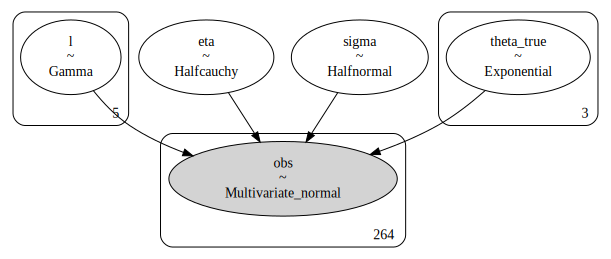

In [10]:
pm.model_to_graphviz(model)

## 5. MCMC 샘플링 수행

이 섹션에서는 NUTS (No-U-Turn Sampler)를 사용하여 사후 분포에서 샘플링을 수행합니다. MCMC를 통해 미지의 파라미터 theta와 하이퍼파라미터들의 사후 분포를 근사합니다.

## MCMC 샘플링 설정 및 설명

### MCMC (Markov Chain Monte Carlo) 개요

MCMC는 Bayesian 추론에서 사후 분포를 근사하기 위한 핵심 기법입니다. 우리가 정의한 모델에서 사후 분포는 다음과 같이 정의됩니다:

TODO: X 넣어서 식 전개

$$p(\theta, l, \eta, \sigma | Y) \propto p(Y | \theta, l, \eta, \sigma) \cdot p(\theta) \cdot p(l) \cdot p(\eta) \cdot p(\sigma)$$

이 복잡한 다차원 분포를 직접 계산하기 어려우므로, MCMC를 통해 사후 분포에서 샘플을 생성합니다.

### 사용된 샘플러: NUTS (No-U-Turn Sampler)

#### **NUTS 선택 이유**
```python
nuts_sampler="numpyro"
```

**NUTS (No-U-Turn Sampler)**는 Hamiltonian Monte Carlo (HMC)의 개선된 버전으로, 다음과 같은 장점이 있습니다:

1. **자동 튜닝**: step size와 integration time을 자동으로 조정
2. **효율성**: 다른 MCMC 방법보다 빠른 수렴
3. **안정성**: 복잡한 분포에서도 안정적인 샘플링
4. **수치적 안정성**: GP 모델의 고차원 공간에서 우수한 성능

#### **NumPyro 백엔드**
- **PyTorch 기반**: GPU 가속 지원 가능
- **JIT 컴파일**: 샘플링 속도 향상
- **메모리 효율성**: 대용량 데이터셋에서 우수한 성능

### 샘플링 파라미터 상세 설명

#### **1. 샘플링 설정**
```python
draws=1000, tune=1000, chains=1, cores=1
```

**`draws=1000`**: 
- **의미**: 실제 샘플링할 체인 길이
- **목적**: 사후 분포 근사를 위한 충분한 샘플 수
- **고려사항**: 모델 복잡도와 수렴성에 따라 조정 가능

**`tune=1000`**:
- **의미**: 버닝/웜업 단계 길이
- **목적**: 샘플러 파라미터(step size, mass matrix 등) 최적화
- **중요성**: 수렴성에 결정적 영향을 미치는 단계

**`chains=1`**:
- **의미**: 샘플링할 체인 수
- **제한**: 단일 체인으로 수렴 진단 제한
- **권장사항**: 일반적으로 2-4개 체인 사용 권장

**`cores=1`**:
- **의미**: 병렬 처리에 사용할 CPU 코어 수
- **제한**: 단일 코어 사용으로 병렬화 제한

#### **2. 수렴성 설정**
```python
target_accept=0.95
```

**`target_accept=0.95`**:
- **의미**: 목표 수락률 95%
- **목적**: NUTS의 step size 자동 조정 기준
- **최적값**: 일반적으로 0.8-0.95 범위
- **높은 값**: 더 보수적인 샘플링, 안정적이지만 느림

### NUTS 알고리즘 동작 원리

#### **Hamiltonian Dynamics 기반**
NUTS는 다음과 같은 과정을 거칩니다:

1. **Momentum 생성**: $p \sim \mathcal{N}(0, M)$
2. **Hamiltonian 계산**: $H = U(q) + K(p)$
3. **Trajectory 생성**: Leapfrog integration으로 경로 생성
4. **U-Turn 감지**: 효율적인 경로 길이 자동 결정
5. **샘플 수락/거부**: Metropolis-Hastings 기준 적용

여기서:
- $q$: 위치 변수 (모델 파라미터)
- $p$: 모멘텀 변수
- $U(q)$: 잠재 에너지 (negative log-posterior)
- $K(p)$: 운동 에너지
- $M$: 질량 행렬 (보통 단위 행렬)

### 수렴성 진단 고려사항

#### **단일 체인의 한계**
```python
chains=1
```

현재 토이프라블럼을 정의하기 위한 작업 속도 때문에 단일 체인을 사용했으나 이는 다음과 같은 제한이 있음에 주의해야 합니다:

1. **$\hat{R}$ (R-hat) 계산 불가**: 체인 간 수렴성 진단 불가
2. **ESS (Effective Sample Size) 제한**: 정확한 ESS 계산 어려움
3. **수렴성 검증 어려움**: 체인 내 변동성만으로 수렴 판단

#### **개선 방안**
```python
# 권장 설정 (주석 처리된 개선안)
# chains=4, cores=4  # 4개 체인으로 병렬 샘플링
# target_accept=0.8   # 더 일반적인 수락률
```

### 샘플링 성능 최적화

#### **메모리 및 속도 최적화**
```python
# progressbar=False  # 진행 표시줄 비활성화
# nuts_sampler_kwargs={"progress_bar": False}
```

#### **GPU 활용 가능성**
NumPyro 백엔드 사용으로 GPU 가속이 가능합니다:
```python
# GPU 사용 시 (선택사항)
# import jax
# jax.devices()  # GPU 확인
```

### 사후 분석을 위한 샘플 구조

생성된 `trace` 객체는 다음과 같은 구조를 가집니다:

```python
trace.posterior  # 사후 분포 샘플
├── theta: (chain, draw, theta_dim)
├── ls: (chain, draw, ls_dim) 
├── eta: (chain, draw)
└── sigma: (chain, draw)
```

### 샘플링 품질 평가

#### **주요 진단 지표**
1. **수렴성**: Trace plot, $\hat{R}$, ESS
2. **혼합**: Autocorrelation, effective sample size
3. **안정성**: Geweke diagnostic, Gelman-Rubin statistic

#### **실용적 고려사항**
- **충분한 샘플 수**: 사후 분포의 특성을 잘 포착
- **적절한 버닝**: 초기 샘플의 영향 제거
- **수렴 확인**: 시각적 및 통계적 진단 필수



In [11]:
with model:
    # MCMC 샘플링 실행
    # NUTS (No-U-Turn Sampler): Hamiltonian Monte Carlo의 개선된 버전
    trace = pm.sample(
        draws=1000,              # 샘플링할 체인 길이 (실제 샘플 개수)
        tune=1000,               # 워밍업/버닝 단계 길이 (샘플러 파라미터 튜닝)
        chains=1,                # 샘플링할 체인 수 (수렴성 진단을 위해 보통 4개 권장)
        cores=1,                 # 병렬 처리에 사용할 CPU 코어 수
        nuts_sampler="numpyro",  # NumPyro 백엔드 사용 (빠른 성능과 GPU 지원)
        target_accept=0.95,      # 목표 수락률 (높을수록 보수적이고 안정적)
        random_seed=42,
    )

/home/xlsw91/Workspace/pymc-examples/.venv/lib/python3.11/site-packages/pytensor/link/c/cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
sample: 100%|██████████| 2000/2000 [03:14<00:00, 10.30it/s, 31 steps of size 1.12e-01. acc. prob=0.96]
Only one chain was sampled, this makes it impossible to run some convergence checks


## 6. 사후 분포 분석 및 시각화

### Length-scale 해석

Length-scale 파라미터 `l`가 큰 값을 가진다는 것은 해당 차원에서 입력값이 크게 변해도 출력값의 변화가 작다는 의미다. 이는 해당 변수가 출력에 미치는 영향이 상대적으로 작다는 것을 시사한다.

**주의사항**: 
- 변수의 스케일(정규화 방법)에 따라 length-scale 값이 달라지므로 절대적인 비교보다는 상대적인 비교가 중요하다
- 모든 변수를 [0, 1]로 정규화했으므로 length-scale 간 직접 비교가 가능하다

아래 시각화를 보면 차원 2, 3, 4 (theta1, theta2, theta3)의 length-scale이 차원 0, 1 (x1, x2)보다 큰 경향을 보인다. 이는 공간 변수(온도, 습도)가 파라미터보다 에너지 소비량에 더 큰 영향을 미친다는 것을 의미한다. 

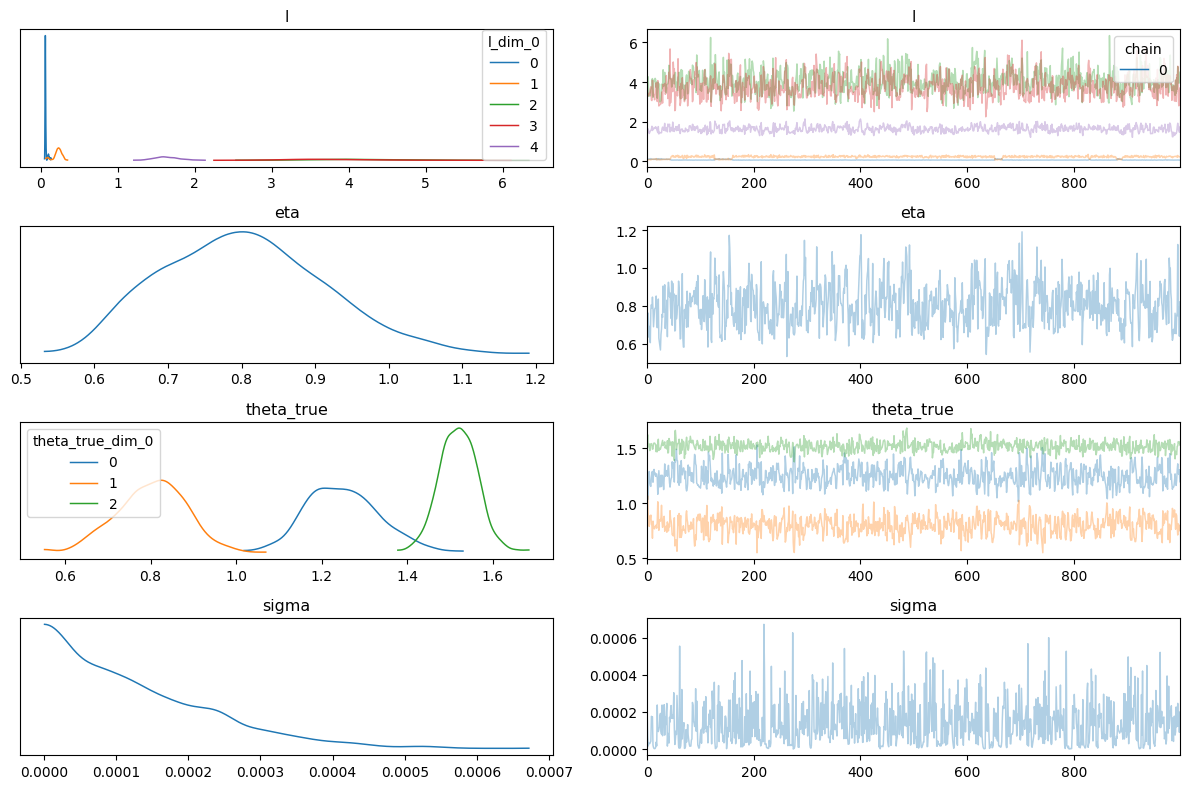

In [12]:
# 사후 분포 trace 플롯 생성
# 왼쪽 열: 각 파라미터의 사후 분포 히스토그램
# 오른쪽 열: MCMC 샘플링 과정에서의 파라미터 값 변화 (수렴성 진단)
az.plot_trace(trace, legend=True)
plt.tight_layout()
plt.show()

## 원래 차원으로 복원하여 함수 파라미터 시각화

### 역변환의 필요성

MCMC 샘플링을 통해 얻은 `theta_true` 파라미터들은 **정규화된 [0, 1] 범위**에 있습니다. 하지만 실제 물리적 해석과 비교를 위해서는 **원래의 물리적 단위**로 복원해야 합니다.

### 역변환 과정

#### **1. 정규화 파라미터 복원**
```python
trace_ = trace.copy()
trace_.posterior.theta_true.values *= theta_max[None, None, :]
```

**수학적 표현**:
$$\theta_{true,\text{original}} = \theta_{true,\text{normalized}} \times \theta_{\text{max}}$$

여기서:
- $\theta_{true,\text{normalized}}$: MCMC로 샘플링된 정규화된 파라미터 [0, 1]
- $\theta_{\text{max}}$: 정규화 시 사용된 최댓값 벡터
- $\theta_{true,\text{original}}$: 원래 물리적 단위의 파라미터

#### **2. 차원 구조 설명**
```python
theta_max[None, None, :]
```

이 표현의 차원 구조:
- `theta_max`: (3,) - 3개 파라미터의 최댓값
- `[None, None, :]`: (1, 1, 3) - 브로드캐스팅을 위한 차원 확장
- `trace.posterior.theta_true`: (1, 1000, 3) - (chain, draw, parameter)
- 결과: (1, 1000, 3) - 모든 샘플에 대해 역변환 적용



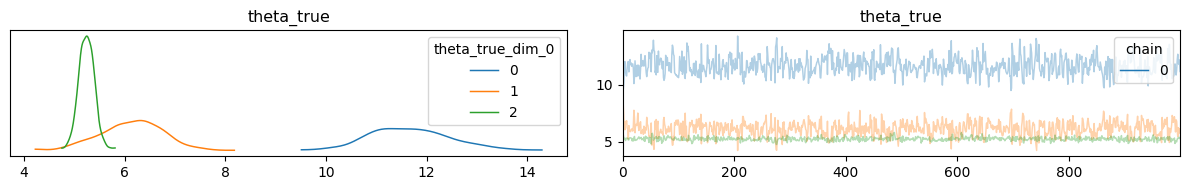

In [13]:
# theta 파라미터를 원래 물리적 단위로 역변환
# 정규화된 [0, 1] 범위에서 원래 파라미터 범위로 복원
trace_ = trace.copy()
trace_.posterior.theta_true.values *= theta_max[None, None, :]  # 브로드캐스팅으로 모든 샘플에 적용

# 역변환된 theta 값들의 사후 분포 시각화
# 이제 물리적 단위로 해석 가능 (기기밀도, 조명밀도, COP)
az.plot_trace(trace_, legend=True, var_names=["theta_true"])
plt.tight_layout()
plt.show()

### 파라미터 간 상관관계 분석

Pair plot을 통해 파라미터 간의 상관관계를 확인할 수 있다. theta[0]과 theta[1] (기기밀도와 조명밀도) 사이에 강한 양의 상관관계가 관찰된다. 이는 두 파라미터가 에너지 소비에 유사한 방식으로 기여하기 때문일 수 있다.

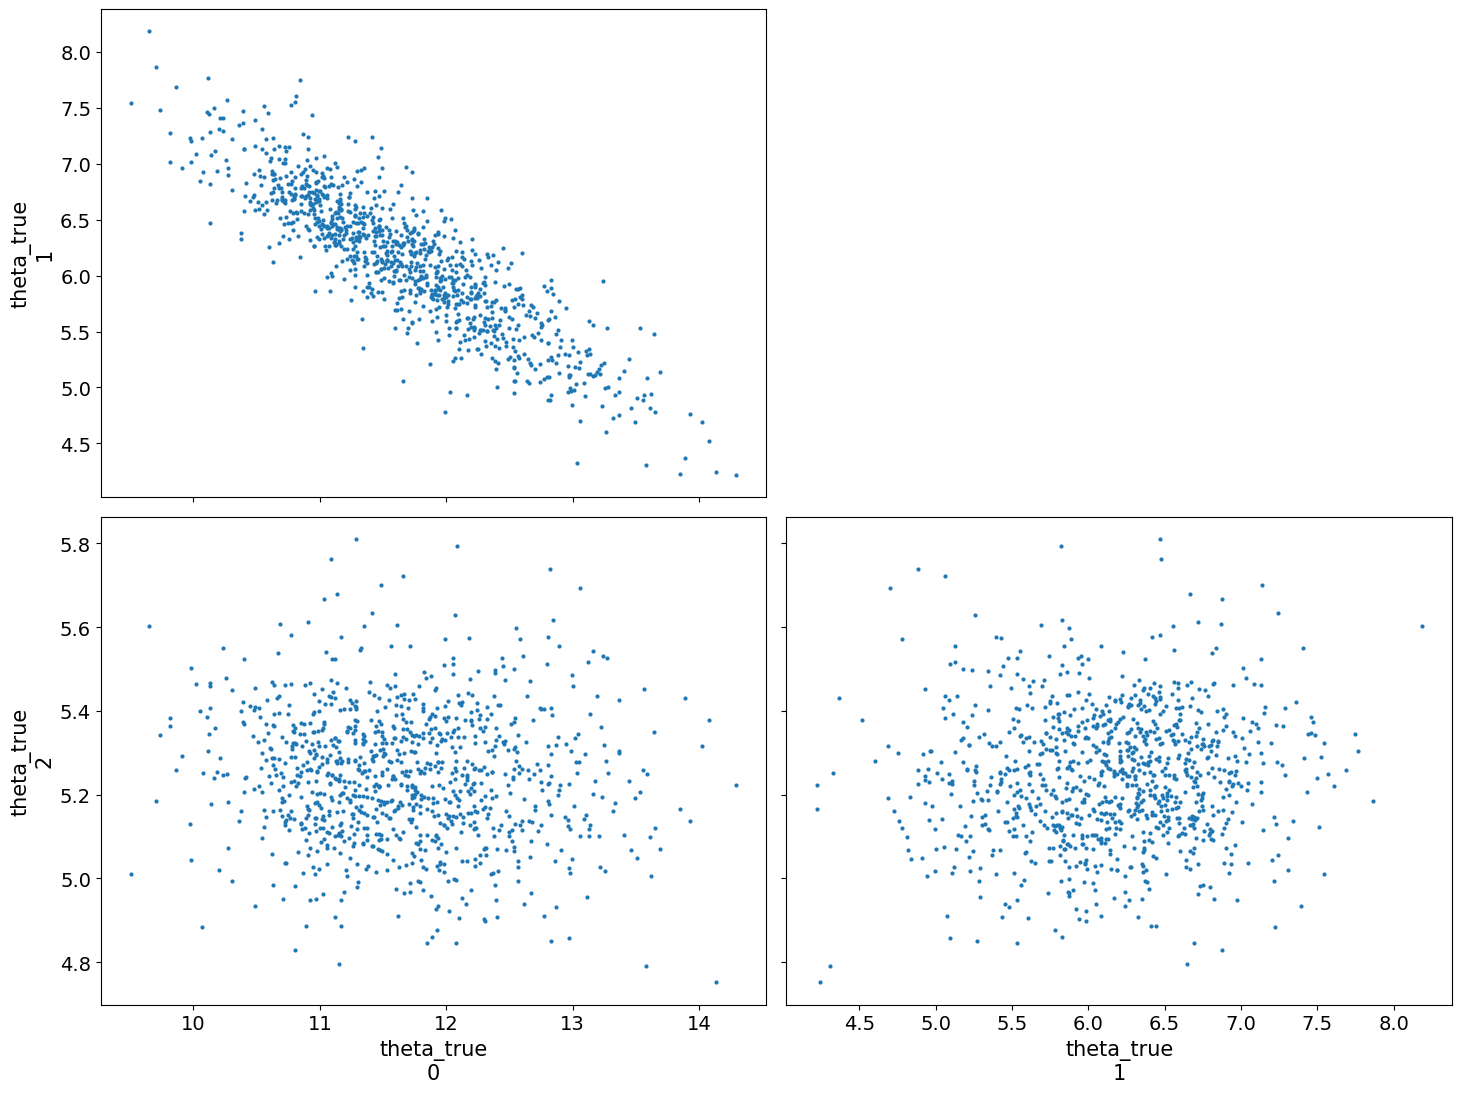

In [14]:
# theta 파라미터 간의 상관관계 시각화
# 대각선: 각 파라미터의 주변 분포 (marginal distribution)
# 비대각선: 파라미터 쌍 간의 결합 분포 (joint distribution)
# 이를 통해 파라미터 간의 상관성과 불확실성 구조 파악
az.plot_pair(trace_, var_names=["theta_true"])
plt.tight_layout()
plt.show()

In [15]:
# MCMC 샘플링 결과 요약 확인
# 각 파라미터의 평균, 표준편차, 신뢰구간 등의 통계량 표시
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

## 7. 사후 예측 분포 (Posterior Predictive Distribution)

이 섹션에서는 학습된 GP 모델을 사용하여 새로운 위치에서의 예측을 수행한다. 1번과 7번 포인트를 연결하는 직선 상의 100개 지점에서 에너지 소비량을 예측하여 모델의 성능과 불확실성을 시각화한다.

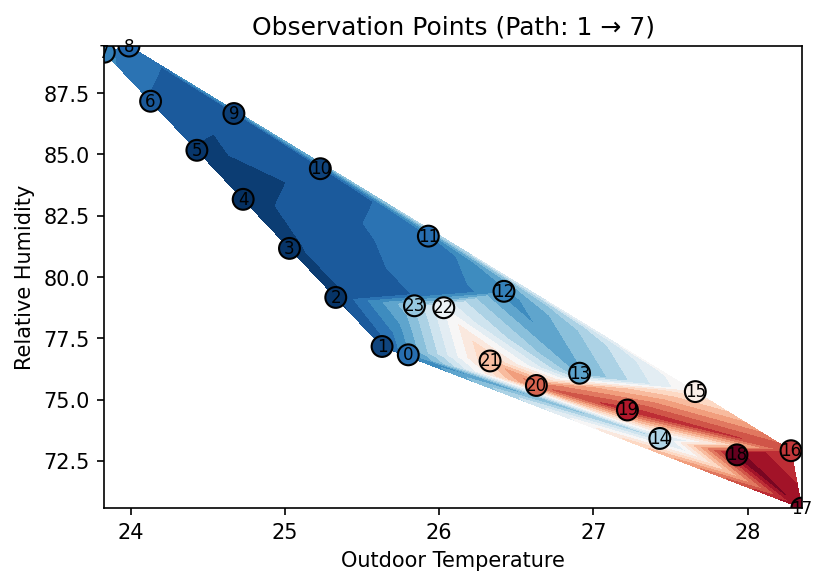

In [16]:
# 실제 관측 데이터의 공간 분포 재시각화 (예측 경로 확인용)
# 1번과 7번 포인트를 연결하는 경로를 따라 예측을 수행할 예정
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)

# 등고선 플롯으로 에너지 소비 패턴 시각화
ax.tricontourf(
    df_f.iloc[:, 1],  # 외기온도
    df_f.iloc[:, 2],  # 상대습도
    df_f.iloc[:, 0],  # 에너지 소비량
    levels=20,
    cmap="RdBu_r"
)

# 관측 데이터 포인트 표시
ax.scatter(
    df_f.iloc[:, 1],
    df_f.iloc[:, 2],
    c=df_f.iloc[:, 0],
    cmap="RdBu_r",
    edgecolors='black',
    s=100

)

# 각 포인트에 인덱스 번호 표시
for i in range(df_f.shape[0]):
    ax.text(
        df_f.iloc[i, 1],
        df_f.iloc[i, 2],
        str(i),
        color="black",
        fontsize=8,
        ha='center',
        va='center'
    )

# 축 레이블 설정
ax.set_xlabel("Outdoor Temperature")
ax.set_ylabel("Relative Humidity")
ax.set_title("Observation Points (Path: 1 → 7)")

plt.show()

In [17]:
# 새로운 예측 위치 정의
# 관측 데이터의 1번과 7번 포인트를 연결하는 직선 상에서 100개 지점 생성
# 이를 통해 1차원적인 변화 패턴을 시각화할 수 있음
x1 = np.linspace(x_p[1, 0], x_p[7, 0], 100)  # x1 좌표를 100개로 균등 분할
x2 = np.linspace(x_p[1, 1], x_p[7, 1], 100)  # x2 좌표를 100개로 균등 분할
x_p_new = np.stack([x1, x2], axis=1)          # 2D 좌표로 결합

# 예측 위치에 추정된 theta 파라미터 결합
# 사후 분포에서 샘플링된 theta 값들이 각 예측에 사용됨
X_p_new = pt.concatenate([x_p_new, pt.tile(theta_true, (x_p_new.shape[0], 1))], axis=1)

with model:
    # 사후 예측 분포 샘플링
    # gp.conditional: 학습된 GP를 사용하여 새로운 위치에서의 조건부 분포 계산
    # pred_noise=True: 관측 노이즈를 포함한 예측 (실제 측정값 시뮬레이션)
    z_pred = gp.conditional("z_pred", Xnew=X_p_new, pred_noise=True)

    # 사후 예측 샘플 생성
    # MCMC trace에서 샘플링된 각 파라미터 조합에 대해 예측 수행
    # 결과: (n_chains * n_draws) x (n_pred_points) 크기의 예측 샘플
    samples = pm.sample_posterior_predictive(
        trace,
        var_names=["z_pred"],
    )

Sampling: [z_pred]


Output()

In [18]:
# GP 결과 시각화를 위한 유틸리티 함수 임포트
# plot_gp_dist: 사후 예측 분포의 평균, 신뢰구간, 샘플을 한 번에 시각화
from pymc.gp.util import plot_gp_dist

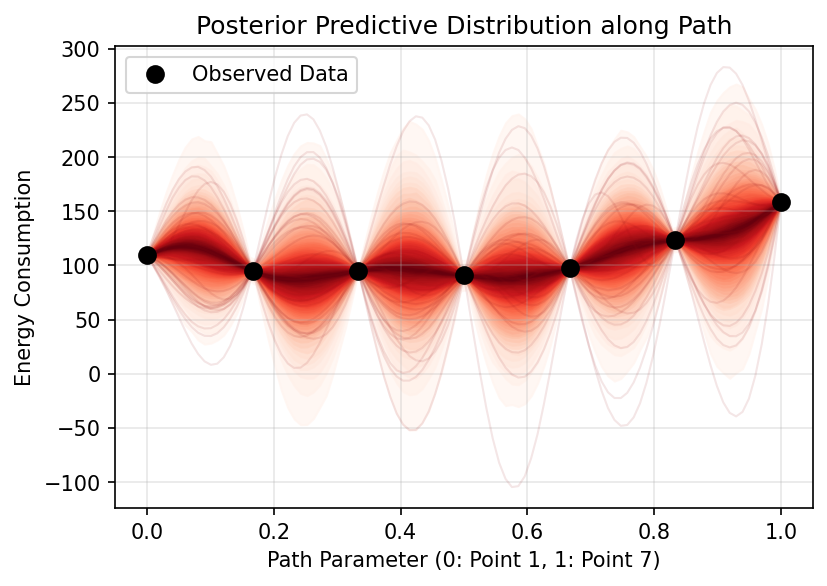

In [19]:
# 사후 예측 분포 시각화
# x축: 1번~7번 포인트를 연결하는 직선의 매개변수 t ∈ [0, 1]
#      t=0일 때 1번 포인트, t=1일 때 7번 포인트

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)

# 예측 샘플 추출 및 역정규화
# 정규화된 [0, 1] 범위를 원래 물리적 단위로 변환
y_pred_samples = az.extract(samples, group="posterior_predictive", var_names=["z_pred"])
y_pred_samples = y_pred_samples * (y_max - y_min) + y_min

# GP 분포 시각화
# - 진한 선: 예측 평균
# - 연한 영역: 95% 신뢰구간 (예측 불확실성)
# - 얇은 선들: 개별 사후 샘플들
plot_gp_dist(ax, samples=y_pred_samples.T, x=np.linspace(0, 1, 100))

# 실제 관측 데이터 포인트 표시
# 1번~7번 포인트의 실제 측정값을 역정규화하여 플롯
ax.plot(np.linspace(0, 1, 7), z[1:7+1] * (y_max - y_min) + y_min, 
        'o', color='black', markersize=8, label='Observed Data', zorder=10)

# 축 레이블 및 제목 설정
ax.set_xlabel("Path Parameter (0: Point 1, 1: Point 7)")
ax.set_ylabel("Energy Consumption")
ax.set_title("Posterior Predictive Distribution along Path")
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()